#IT0425 - Introducción a la Inteligencia Artificial

### Otoño 2023

### IT0425_Lab_2.6

**Profesor Enrique Naredo García**

<font size = 2>
©️ Todos los derechos reservados. All rights reserved.

*Nota: El presente documento es una herramienta diseñada única y exclusivamente para los estudiantes de la asignatura arriba mencionada. Se recuerda no compartir esta información fuera de los integrantes registrados en este curso. La reproducción total o parcial de este documento requiere autorización por escrito del titular del copyright.*
</font>

In [ ]:
# librerías
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# monta drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importa las palabras de wikipedia
candidate_sentences = pd.read_csv("/content/drive/MyDrive/Datasets/wiki_sentences_v2.xls")
candidate_sentences.shape

(4318, 1)

In [ ]:
# muestra las oraciones
candidate_sentences

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [ ]:
# ejemplo de tokenización
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
# obtiene etiquetas
def get_entities(sent):
  ## pedazo 1
  ent1 = ""
  ent2 = ""
  # dependencia la etiqueta del token anterior en la oración
  prv_tok_dep = ""
  # token anterior en la oración
  prv_tok_text = ""
  prefix = ""
  modifier = ""


  for tok in nlp(sent):
    ## pedazo 2
    # si el token es una puntuación, entonces muevelo al siguiente token
    if tok.dep_ != "punct":
      # checa si el token es una palabra compuesta
      if tok.dep_ == "compound":
        prefix = tok.text
        # si la anterior palabra fue también compuesta, entonces agrega la palabra actual
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # checa si el token es un modificador
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # si la palabra anterior
        # si la anterior palabra fue también compuesta, entonces agrega la palabra actual
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## pedazo 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## pedazo 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## pedazo 5
      # actualiza las variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:41<00:00, 104.47it/s]


In [ ]:
entity_pairs

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['', 'outside cult him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men'],
 ['last  which', 'penn'],
 ['jessica chastain', 'same  character'],
 ['mauro fiore', 'cinematographer'],
 ['filming', 'october'],
 ['soundtrack', 'digitally  june'],
 ['album', 'digitally  august'],
 ['film', 'studios motion pictures'],
 ['it', '$ 103.7 million'],
 ['millie thomas aisha', ''],
 ['it', 'executive producer yoshimitsu banno'],
 ['vivienn

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # empareja objetos de clase
  matcher = Matcher(nlp.vocab)

  # define el patrón
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern], on_match=None)

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:41<00:00, 104.16it/s]


In [ ]:
# extrae el sujeto
source = [i[0] for i in entity_pairs]

# extrae el objeto
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# crea un grafo dirigido
G1 = nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

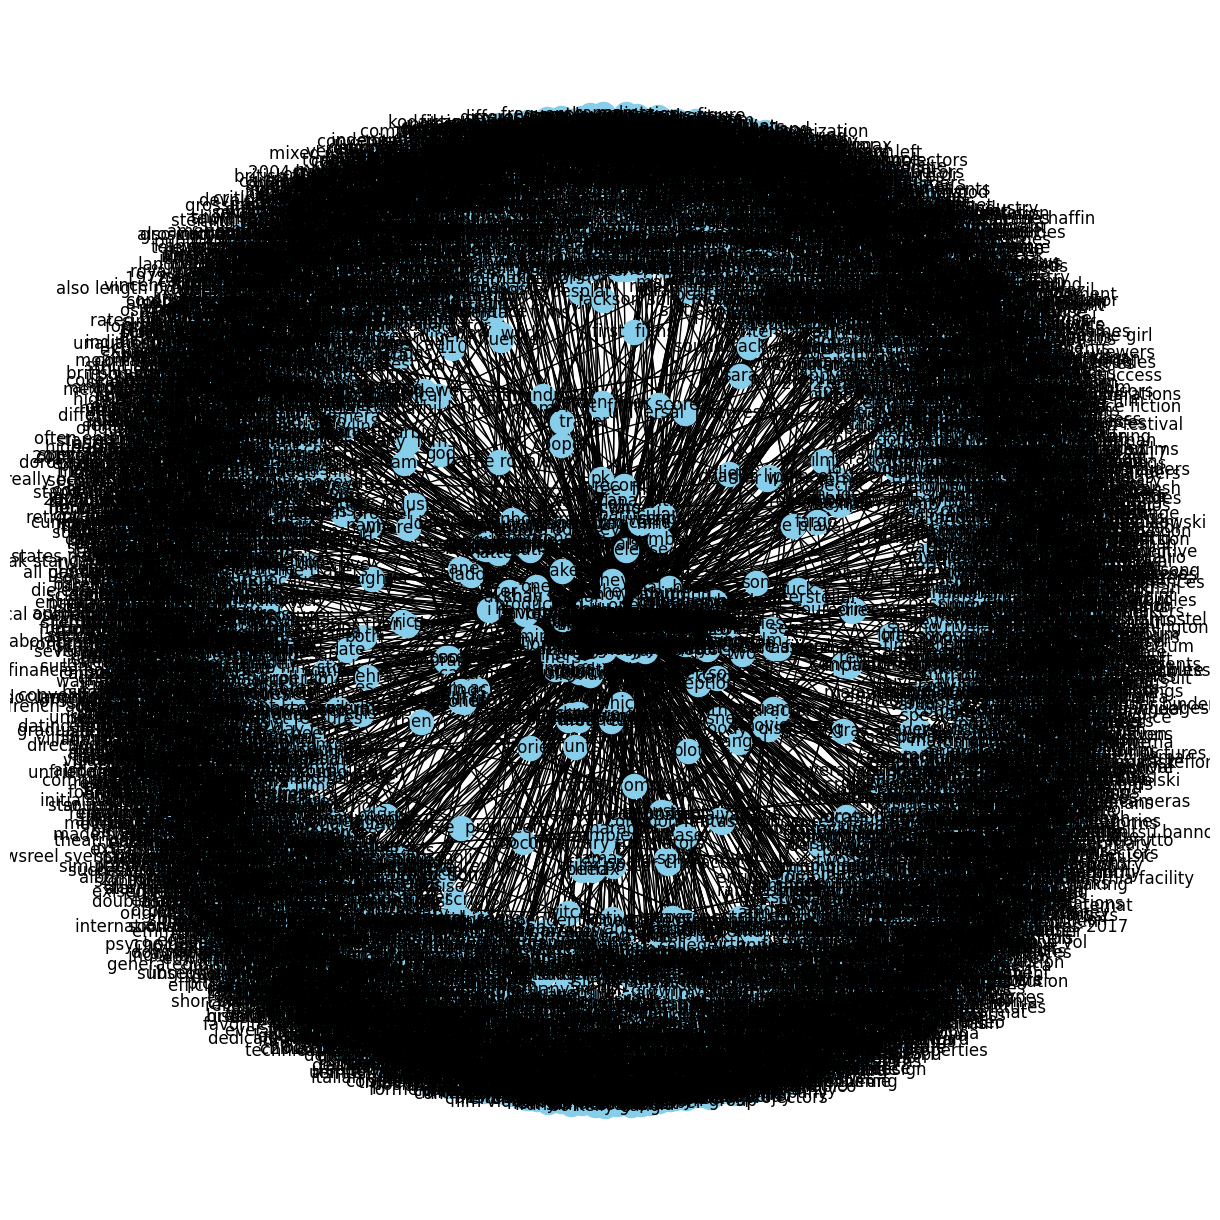

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G1)
nx.draw(G1, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

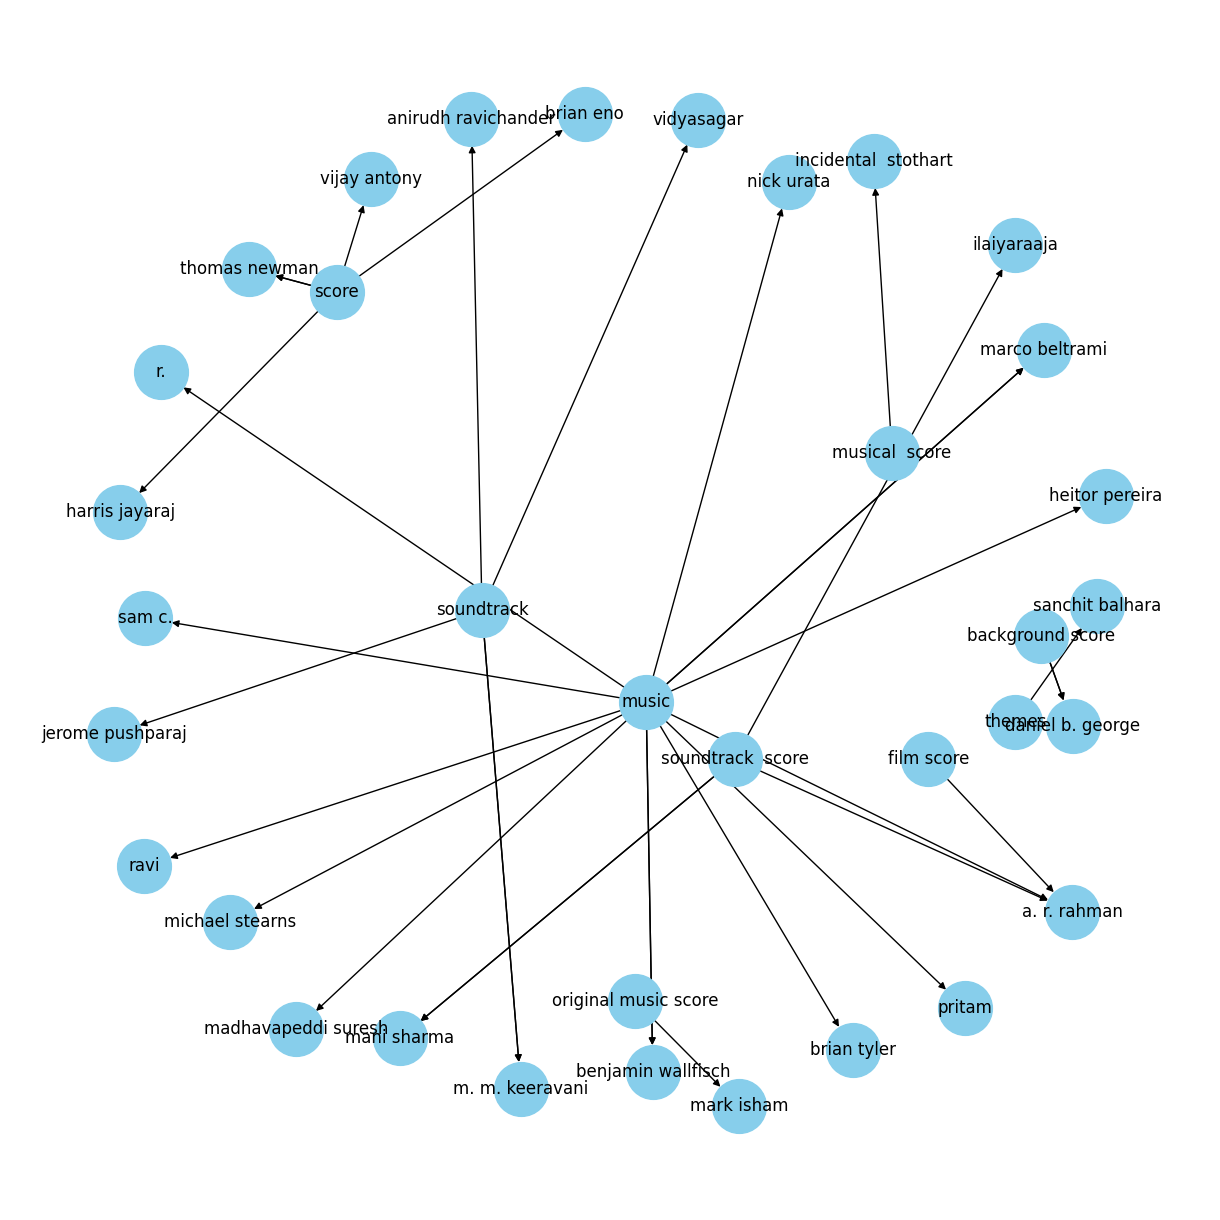

In [ ]:
G2 = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# k regula la distancia entre los nodos
pos = nx.spring_layout(G2, k = 0.5)
nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

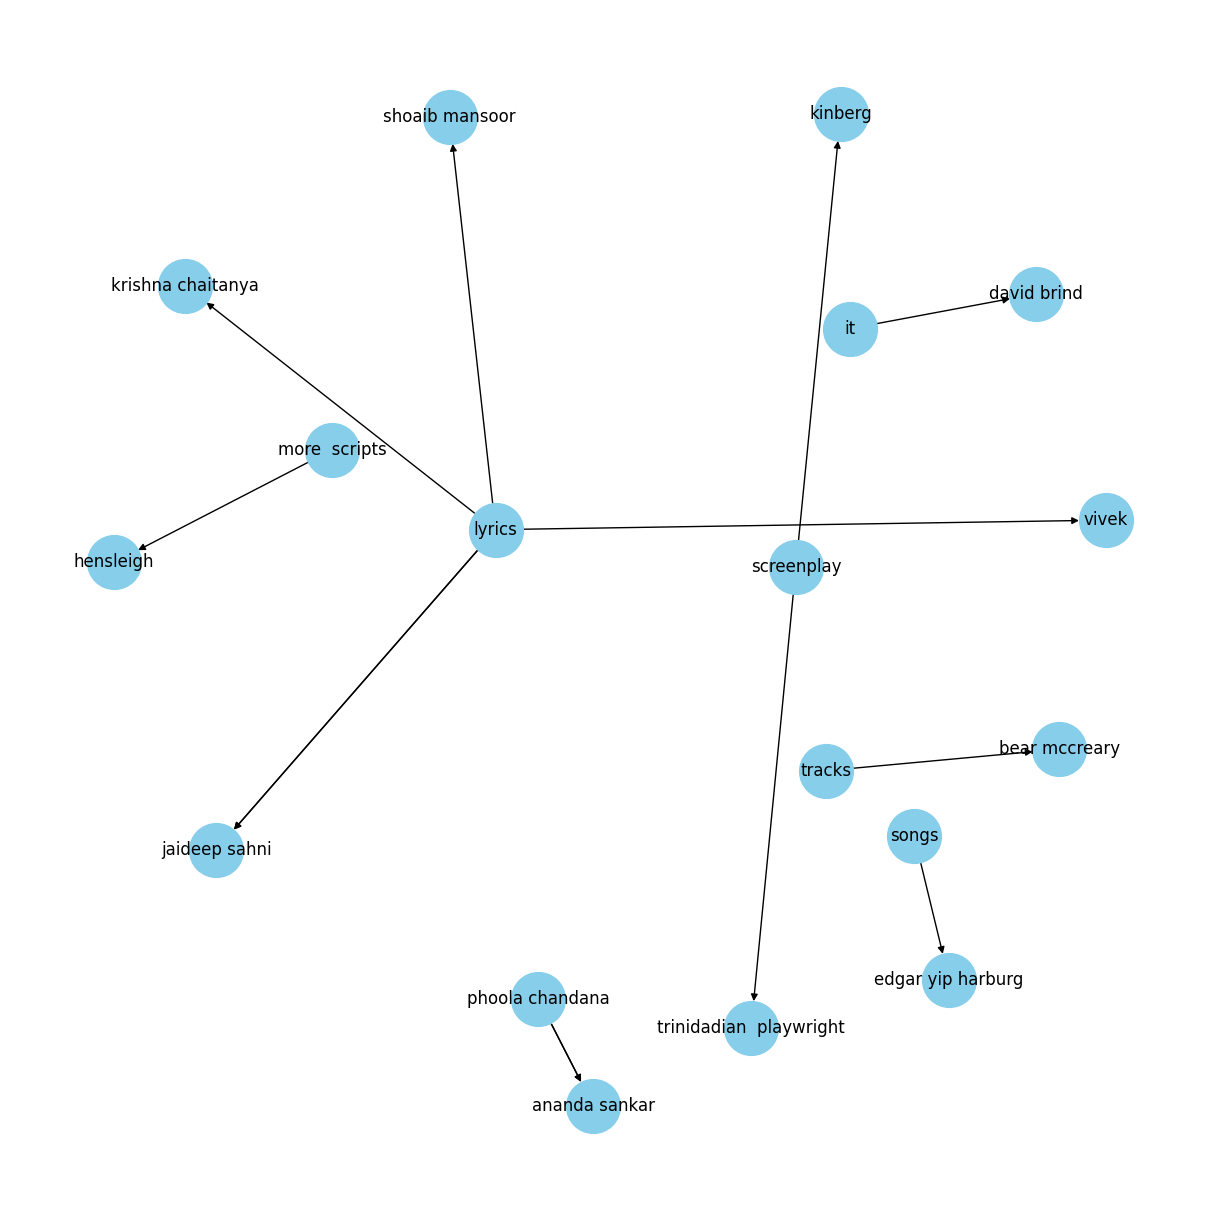

In [ ]:
G3 = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G3, k = 0.5)
nx.draw(G3, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

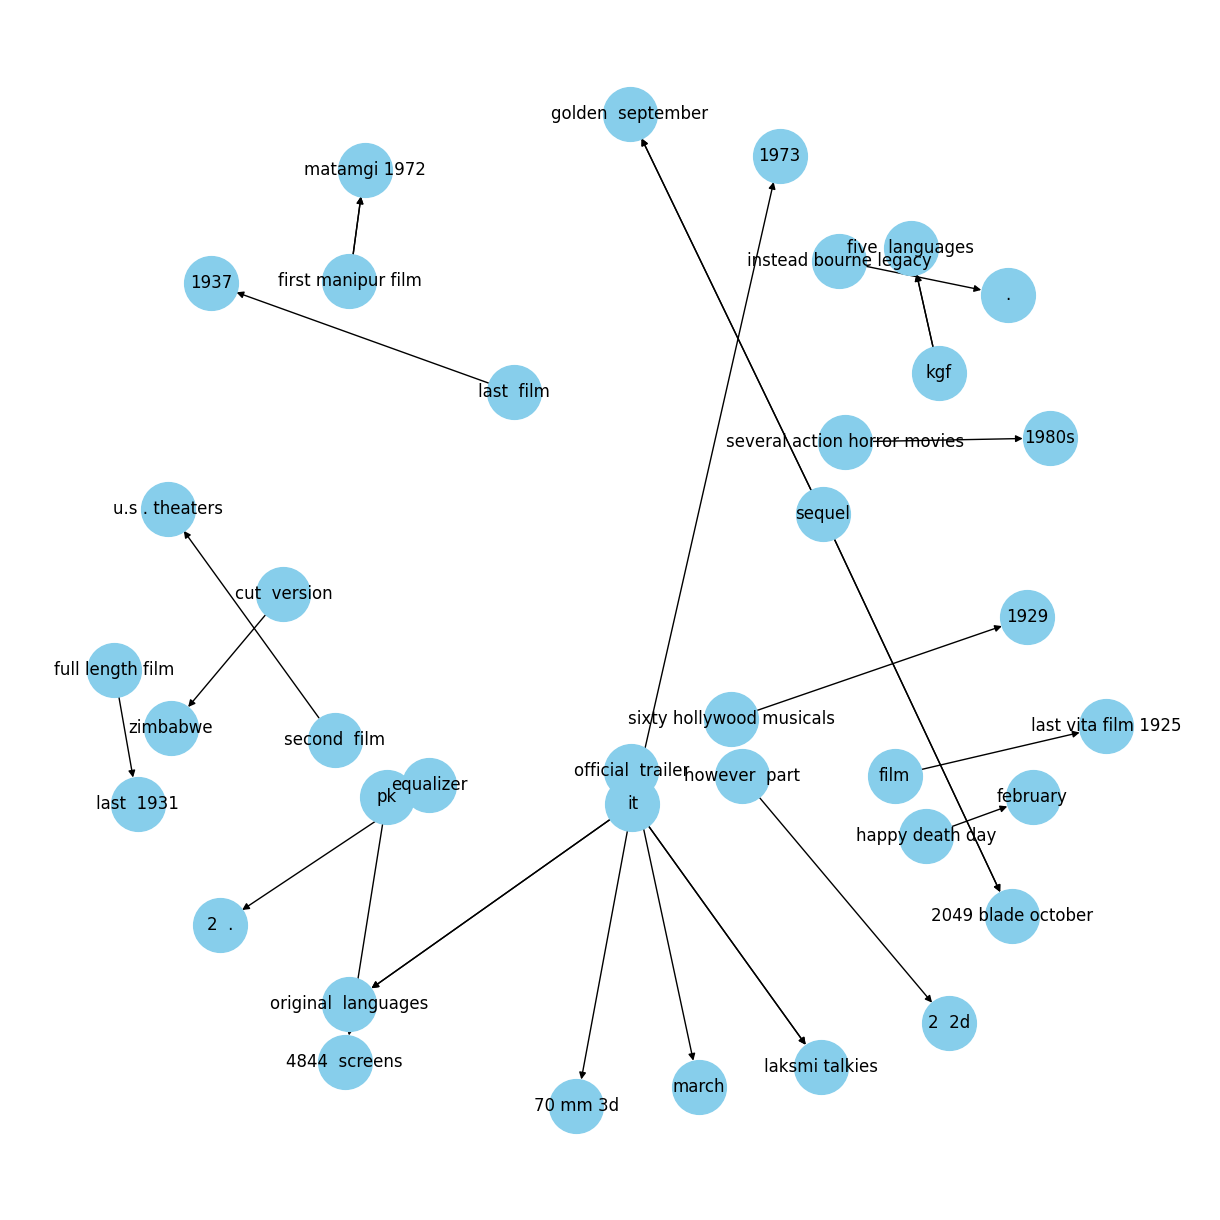

In [ ]:
G4 = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G4, k = 0.5)
nx.draw(G4, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()